<a href="https://colab.research.google.com/github/trungvitlon/Project-KTTT/blob/main/ISAC_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, uniform, randint

# ================== 1. THAM SỐ HỆ THỐNG ==================
Mt = 3
Nt = 16
U = 3
Q = 1
S = U + Q
DIMENSION = Mt * Nt * S * 2

MAX_POWER = 1.0
MIN_SINR_THRES = np.full(U, 0.5)
# PENALTY_FACTOR = 10000000

MU = 30
ES_SIGMA_INIT = 0.02
ES_MAX_ITERS = 3000
ES_MU = 0.0
LEARNING_RATE_GLOBAL = 1.0 / np.sqrt(2 * np.sqrt(DIMENSION))
LEARNING_RATE_LOCAL = 1.0 / np.sqrt(2 * DIMENSION)

# ================== 2. KÊNH & ĐÁP ỨNG ==================
def generate_placeholder_channels(U, Mt, Nt):
    H_U = {}
    for u in range(U):
        H_U[u] = {}
        for m in range(Mt):
            H_U[u][m] = (
                normal(0, 1, (Nt, 1)) +
                1j * normal(0, 1, (Nt, 1))
            ) / np.sqrt(2)
    return H_U

def generate_array_response(Mt, Nt, theta_list):
    A_response = {}
    for m in range(Mt):
        n = np.arange(Nt)
        A_response[m] = np.exp(
            1j * np.pi * n * np.sin(theta_list[m])
        ).reshape(Nt, 1)
    return A_response

SENSING_PARAMS = {
    'Zeta_sq': 0.01,
    'Sigma_sq_comm': np.full(U, 1e-6),
    'Sigma_sq_sensing': 1.0
}

# ================== 3. GIẢI MÃ ==================
def vector_to_complex_beamforming(vector_real, Mt, Nt, S):
    f_ms = {}
    complex_vector = vector_real[::2] + 1j * vector_real[1::2]
    for m in range(Mt):
        f_ms[m] = {}
        for s in range(S):
            idx = (m * S + s) * Nt
            f_ms[m][s] = complex_vector[idx:idx + Nt].reshape(Nt, 1)
    return f_ms

# ================== 4. SINR & SNR ==================
def penalty_power(ap_power, p_max, lamda=1000.0, power=2):
    violation = max(0.0, ap_power - p_max)
    return lamda * (violation ** power)

def calculate_power_constraint(f_ms, Mt, S, P_max):
    penalty = 0.0
    for m in range(Mt):
        power = sum(np.sum(np.abs(f_ms[m][s])**2) for s in range(S))
        penalty += penalty_power(power, P_max)
        # if power > P_max:
        #     penalty = PENALTY_FACTOR
    return penalty

def penalty_sinr_db(sinr_lin, gamma_lin,
                    lamda=500.0, eps=1e-12, power=2):

    sinr_db  = 10 * np.log10(sinr_lin + eps)
    gamma_db = 10 * np.log10(gamma_lin + eps)

    violation = max(0.0, gamma_db - sinr_db)
    penalty = lamda * (violation ** power)

    return penalty, sinr_db

def penalty_sinr_lin(sinr_lin, gamma_lin, lamda=1e5, power=2):
    violation = max(0.0, gamma_lin - sinr_lin)
    return lamda * (violation ** power)

def calculate_comm_SINR(f_ms, u, H_U, Mt, U, Q, sigma_sq, gamma,
                        lamda=1e5, power=2):
    desired = sum(H_U[u][m].conj().T @ f_ms[m][u] for m in range(Mt))
    DS = np.abs(desired)**2

    MUI = sum(
        np.abs(sum(H_U[u][m].conj().T @ f_ms[m][u_p] for m in range(Mt)))**2
        for u_p in range(U) if u_p != u
    )

    SI = sum(
        np.abs(sum(H_U[u][m].conj().T @ f_ms[m][s] for m in range(Mt)))**2
        for s in range(U, U + Q)
    )

    SINR = DS / (MUI + SI + sigma_sq + 1e-15)

    penalty = penalty_sinr_lin(float(SINR), float(gamma), lamda=lamda, power=power)
    return float(SINR), float(penalty)

def calculate_sensing_SNR(f_ms, Mt, U, Q, A_resp, params):
    zeta_sq = params['Zeta_sq']
    sigma_sq = params['Sigma_sq_sensing']

    numerator = 0.0
    denominator = Mt * sigma_sq

    for m in range(Mt):
        F_sense = np.hstack([f_ms[m][s] for s in range(U, U + Q)])
        gain = A_resp[m].conj().T @ F_sense
        numerator += zeta_sq * np.sum(np.abs(gain)**2)

    SNR = numerator / (denominator + 1e-15)
    snr_db = 10 * np.log10(SNR + 1e-12)
    return float(SNR), float(snr_db)

def calculate_fitness(x, Mt, Nt, U, Q, P_max, gamma_u, H_U, A_resp, params):
    S = U + Q
    f_ms = vector_to_complex_beamforming(x, Mt, Nt, S)

    penalty = 0.0

    # SINR penalty (linear)
    for u in range(U):
        sinr_u, p = calculate_comm_SINR(
            f_ms, u, H_U, Mt, U, Q,
            params['Sigma_sq_comm'][u], gamma_u[u]
        )
        penalty += p

    # power penalty
    penalty += calculate_power_constraint(f_ms, Mt, S, P_max)

    snr_lin, snr_db = calculate_sensing_SNR(f_ms, Mt, U, Q, A_resp, params)

    return snr_lin, snr_db, penalty

class Individual:
    def __init__(self, x, sigma):
        self.x = x
        self.sigma = sigma
        self.fitness = None
        self.snr = None
        self.penalty = None

# ================== 5. Evolution Strategy ==================
def initialize_population(mu):
    pop = []
    limit = np.sqrt(MAX_POWER / (DIMENSION // 2))
    for _ in range(mu):
        x = uniform(-limit, limit, DIMENSION)
        sigma = np.full(DIMENSION, ES_SIGMA_INIT)
        pop.append(Individual(x, sigma))
    return pop

def mutate(parent):
    N = len(parent.x)
    global_noise = normal()
    sigma = parent.sigma * np.exp(
        LEARNING_RATE_GLOBAL * global_noise +
        LEARNING_RATE_LOCAL * normal(size=N)
    )
    sigma = np.clip(sigma, 1e-6, None)
    x = parent.x + sigma * normal(size=N)
    return Individual(x, sigma)


In [57]:
# ================== 5. (μ + 1)-ES ==================
def es_mu_plus_1(params):
  pop = initialize_population(MU)

  for ind in pop:
    ind.fitness, ind.snr, ind.penalty = calculate_fitness(ind.x, **params)

  history = {'fitness': [], 'snr': [], 'penalty': []}

  for _ in range(ES_MAX_ITERS):
    parent = pop[randint(MU)]
    child = mutate(parent)
    child.fitness, child.snr, child.penalty = calculate_fitness(child.x, **params)
    pop.append(child)

    pop = sorted(pop, key=lambda i: (i.penalty, -i.fitness))[:MU]

    best = pop[0]
    history['fitness'].append(best.fitness)
    history['snr'].append(best.snr)
    history['penalty'].append(best.penalty)

  return best, history

In [58]:
# ================== 5. (μ + λ)-ES ==================
def es_mu_plus_lambda(params, lam=20):
    pop = initialize_population(MU)

    for ind in pop:
        ind.fitness, ind.snr, ind.penalty = calculate_fitness(ind.x, **params)

    history = {'fitness': [], 'snr': [], 'penalty': []}

    for _ in range(ES_MAX_ITERS):
        offspring = []

        # ========== SINH λ OFFSPRING ==========
        for _ in range(lam):
            parent = pop[randint(MU)]
            child = mutate(parent)
            child.fitness, child.snr, child.penalty = calculate_fitness(
                child.x, **params
            )
            offspring.append(child)

        # ========== CHỌN LỌC (μ + λ) ==========
        pop = pop + offspring
        pop = sorted(pop, key=lambda i: (i.penalty, -i.fitness))[:MU]

        best = pop[0]
        history['fitness'].append(best.fitness)
        history['snr'].append(best.snr)
        history['penalty'].append(best.penalty)

    return best, history

In [59]:
# ================== 5. (μ , λ)-ES ==================
def mutate_with_sigma(parent, sigma_scalar):
    """Gaussian mutation with a GLOBAL step size sigma_scalar (1/5 success rule)."""
    N = len(parent.x)
    x_child = parent.x + sigma_scalar * normal(size=N)
    sigma_vec = np.full(N, sigma_scalar)
    return Individual(x_child, sigma_vec)

def es_mu_comma_lambda(params, MU=10, lam=40,
                       c_up=1.2, c_down=1.2,
                       sigma_min=1e-6, sigma_max=0.2,
                       target_success=0.2):

    pop = initialize_population(MU)
    for ind in pop:
        ind.fitness, ind.snr, ind.penalty = calculate_fitness(ind.x, **params)

    history = {'fitness': [], 'snr': [], 'penalty': []}

    # sigma_init theo heuristic 1/10 range
    limit = np.sqrt(MAX_POWER / (DIMENSION // 2))
    sigma = (2 * limit) / 10.0
    sigma = float(np.clip(sigma, sigma_min, sigma_max))

    for _ in range(ES_MAX_ITERS):
        offspring = []
        successes = 0

        # ===== sinh λ offspring =====
        for _ in range(lam):
            parent = pop[randint(len(pop))]

            child = mutate_with_sigma(parent, sigma)
            child.fitness, child.snr, child.penalty = calculate_fitness(child.x, **params)

            if (child.penalty, -child.fitness) < (parent.penalty, -parent.fitness):
                successes += 1

            offspring.append(child)

        # ===== chọn lọc (μ,λ): chỉ chọn từ offspring =====
        pop = sorted(offspring, key=lambda i: (i.penalty, -i.fitness))[:MU]

        # ===== adapt sigma theo success rate =====
        success_rate = successes / lam
        if success_rate > target_success:
            sigma = min(sigma * c_up, sigma_max)
        else:
            sigma = max(sigma / c_down, sigma_min)

        best = pop[0]
        history['fitness'].append(best.fitness)
        history['snr'].append(best.snr)
        history['penalty'].append(best.penalty)

    return best, history

/tmp/ipython-input-2744113502.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  penalty = penalty_sinr_lin(float(SINR), float(gamma), lamda=lamda, power=power)
/tmp/ipython-input-2744113502.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(SINR), float(penalty)


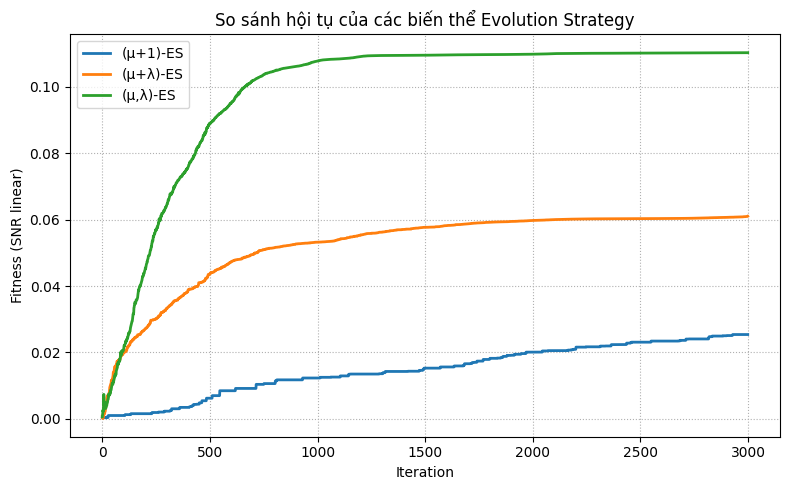

In [60]:
# ================== MAIN ==================
def main():
    H = generate_placeholder_channels(U, Mt, Nt)
    theta = np.random.uniform(-np.pi/2, np.pi/2, Mt)
    A = generate_array_response(Mt, Nt, theta)

    params = dict(
        Mt=Mt, Nt=Nt, U=U, Q=Q,
        P_max=MAX_POWER,
        gamma_u=MIN_SINR_THRES,
        H_U=H,
        A_resp=A,
        params=SENSING_PARAMS
    )

    # ====== CHẠY 3 BIẾN THỂ ======
    best1, hist1 = es_mu_plus_1(params)
    best2, hist2 = es_mu_plus_lambda(params)
    best3, hist3 = es_mu_comma_lambda(params)

    # ====== VẼ CHUNG 1 HÌNH (FITNESS) ======
    plt.figure(figsize=(8, 5))

    plt.plot(hist1['fitness'], label='(μ+1)-ES', linewidth=2)
    plt.plot(hist2['fitness'], label='(μ+λ)-ES', linewidth=2)
    plt.plot(hist3['fitness'], label='(μ,λ)-ES', linewidth=2)

    plt.xlabel("Iteration")
    plt.ylabel("Fitness (SNR linear)")
    plt.title("So sánh hội tụ của các biến thể Evolution Strategy")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
